# Getting started with calibrated-explanations - using the WrapCalibratedExplainer class
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
## Classification
Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml(name="wine", version=7, as_frame=True, parser='auto')

X = dataset.data.values.astype(float)
y = (dataset.target.values == 'True').astype(int)

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2, stratify=y)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)


We now create our wrapper object, using a `RandomForestClassifier` as learner. 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from calibrated_explanations import WrapCalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

classifier = WrapCalibratedExplainer(RandomForestClassifier())
display(classifier)

calibrated_explanations v0.5.0


WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=False, calibrated=False)

We now fit our model using the proper training set.

In [4]:
classifier.fit(X_prop_train, y_prop_train)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=False)

The `WrapCalibratedExplainer` class has a `predict` and a `predict_proba` method that returns the predictions and probability estimates of the underlying classifier. If the model is not yet calibrated, then the underlying models `predict` and `predict_proba` methods are used. If the model is calibrated, then the `predict` and `predict_proba` method of the calibration model is used.

In [5]:
prediction = classifier.predict(X_test)
proba = classifier.predict_proba(X_test)
print('Uncalibrated prediction (probability estimates):')
print(f'{prediction} ({proba})')

Uncalibrated prediction (probability estimates):
[0 1] ([[0.54 0.46]
 [0.45 0.55]])


c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\core.py:2009: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated predictions.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated predictions.", Warning)
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\core.py:2084: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.", Warning)


Before we can generate explanations, we need to calibrate our model using the calibration set. 

In [6]:
classifier.calibrate(X_cal, y_cal, feature_names=feature_names)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=classification, learner=RandomForestClassifier()))

Once the model is calibrated, the `predict` and `predict_proba` methods produce calibrated predictions and probability estimates.

In [7]:
prediction = classifier.predict(X_test)
proba, (low, high) = classifier.predict_proba(X_test, uq_interval=True)
print('Calibrated prediction (probability estimates):')
print(f'{prediction} ({proba})')
print('Calibrated uncertainty interval for the positive class:')
print([(low[i], high[i]) for i in range(len(low))])

Calibrated prediction (probability estimates):
[0 0] ([[0.625      0.375     ]
 [0.57142857 0.42857143]])
Calibrated uncertainty interval for the positive class:
[(np.float64(0.3548387096774194), np.float64(0.3870967741935484)), (np.float64(0.4117647058823529), np.float64(0.4411764705882353))]


#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. 

In [8]:
factual_explanations = classifier.explain_factual(X_test)
display(classifier)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=classification, discretizer=BinaryEntropyDiscretizer(), learner=RandomForestClassifier()))

Once we have the explanations, we can plot all of them using `plot`. Default, a regular plot, without uncertainty intervals included, is created. To include uncertainty intervals, change the parameter `uncertainty=True`.

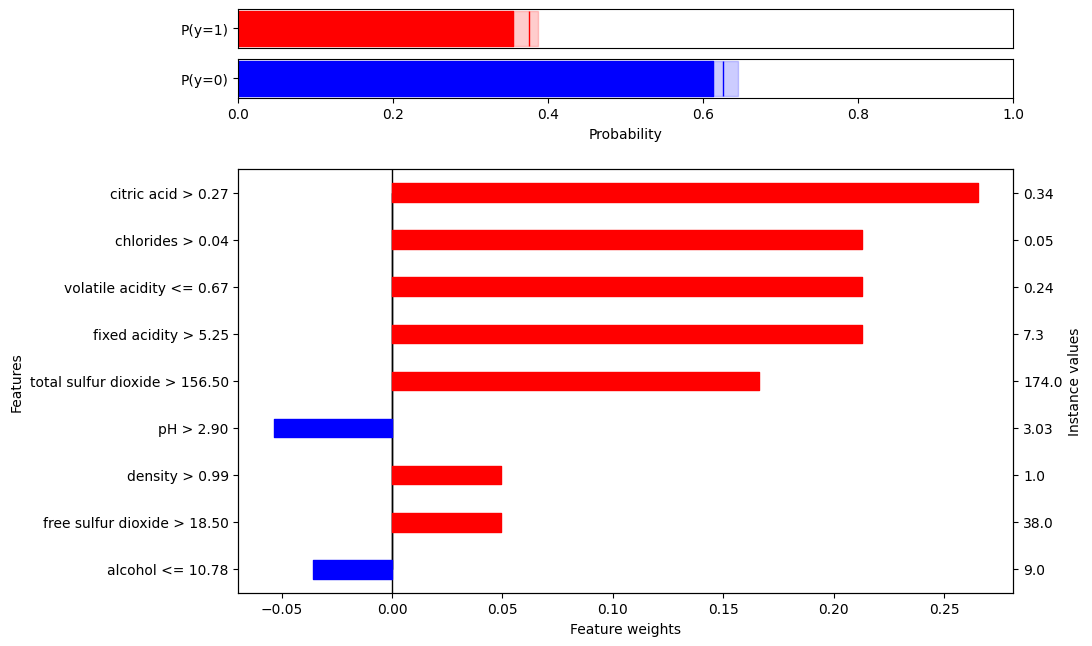

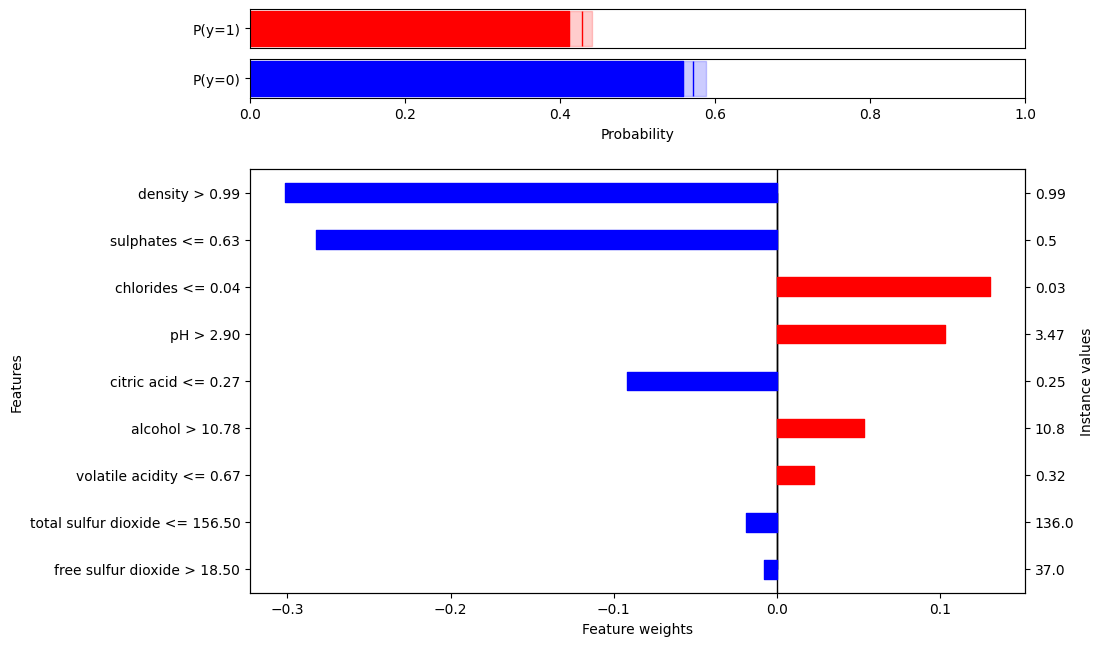

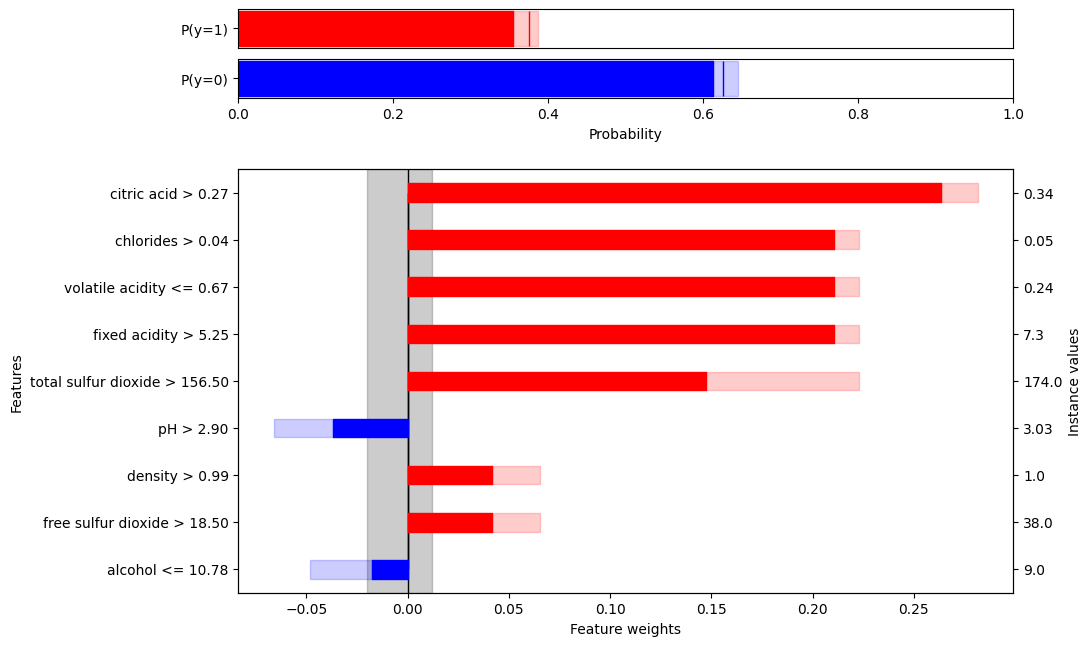

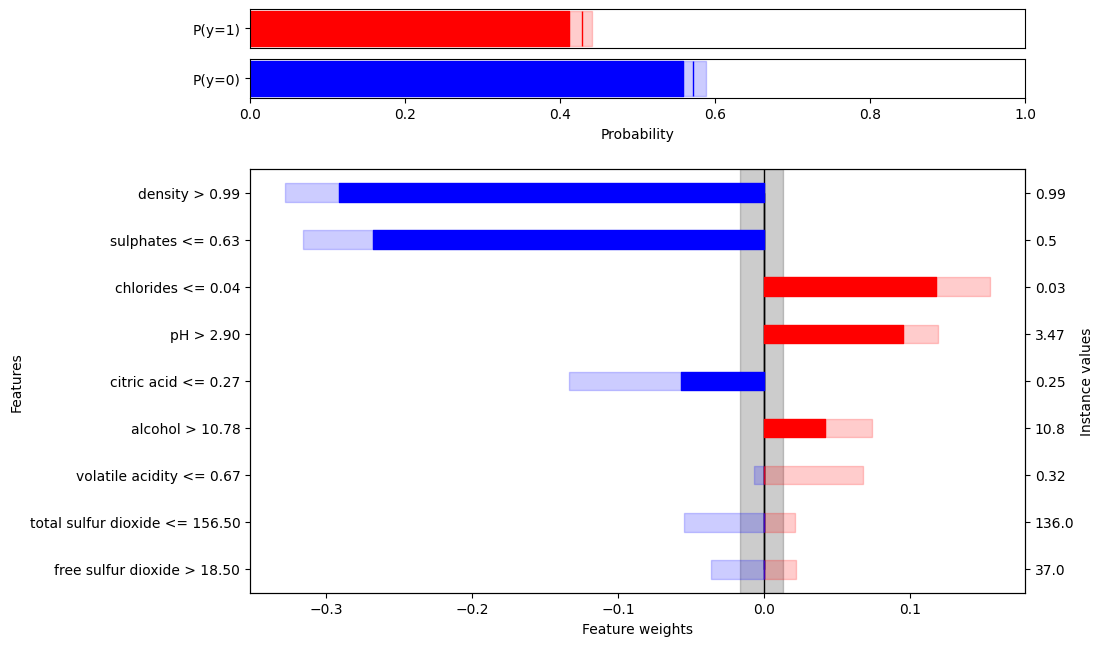

In [9]:
factual_explanations.plot()
factual_explanations.plot(uncertainty=True)

You can also add and remove conjunctive rules.

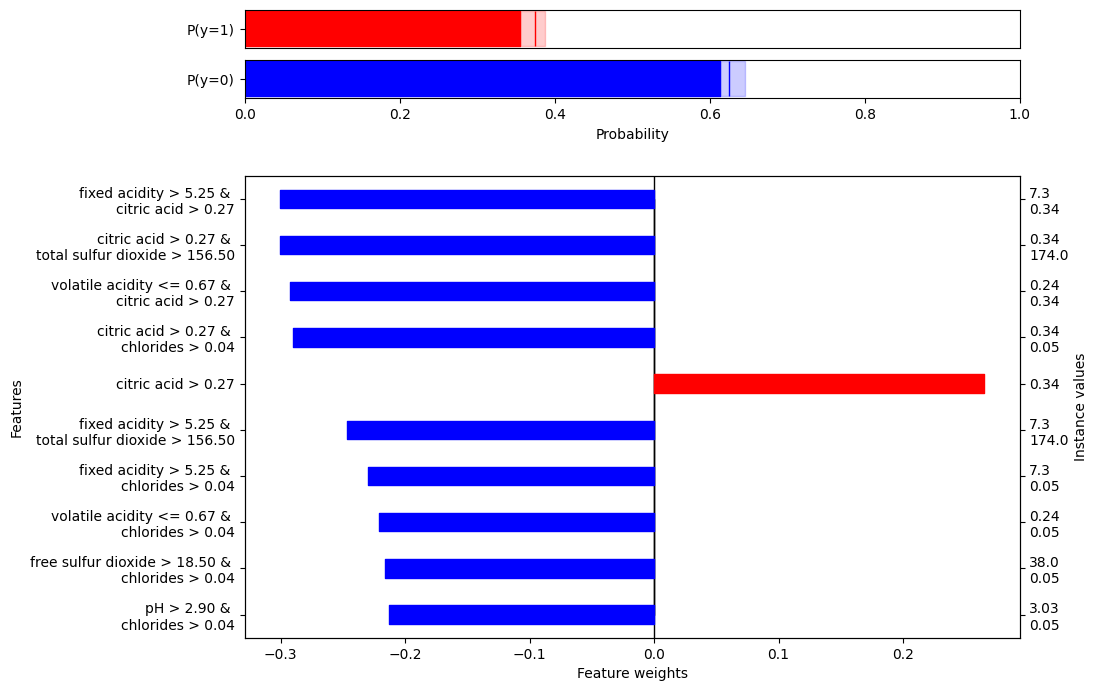

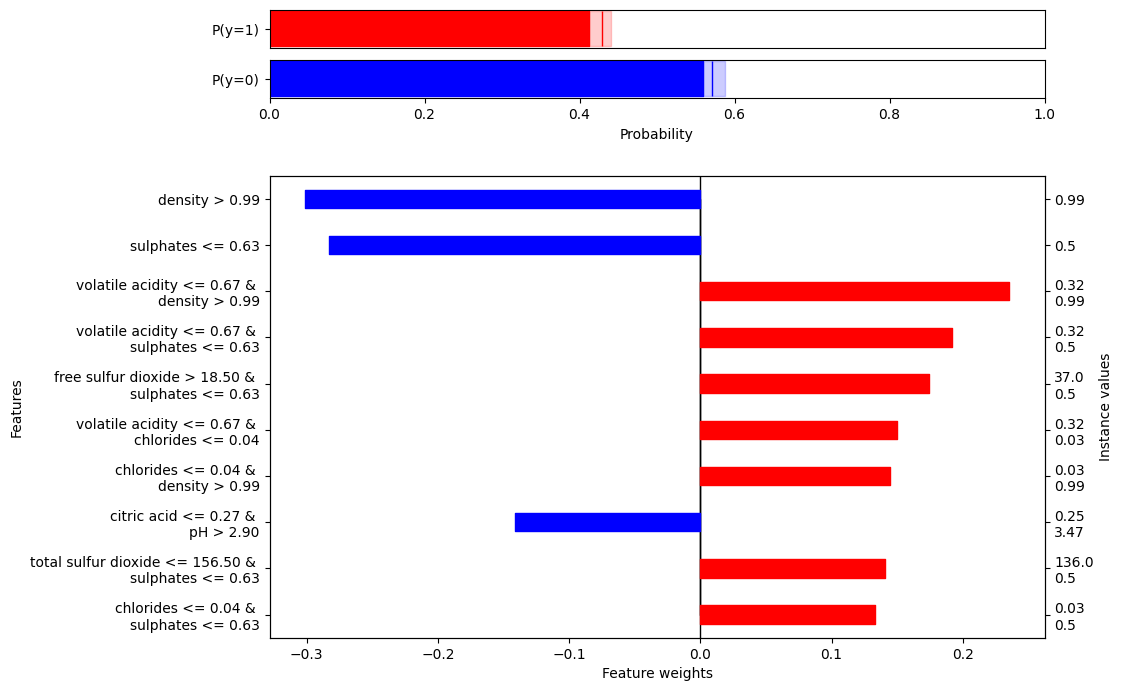

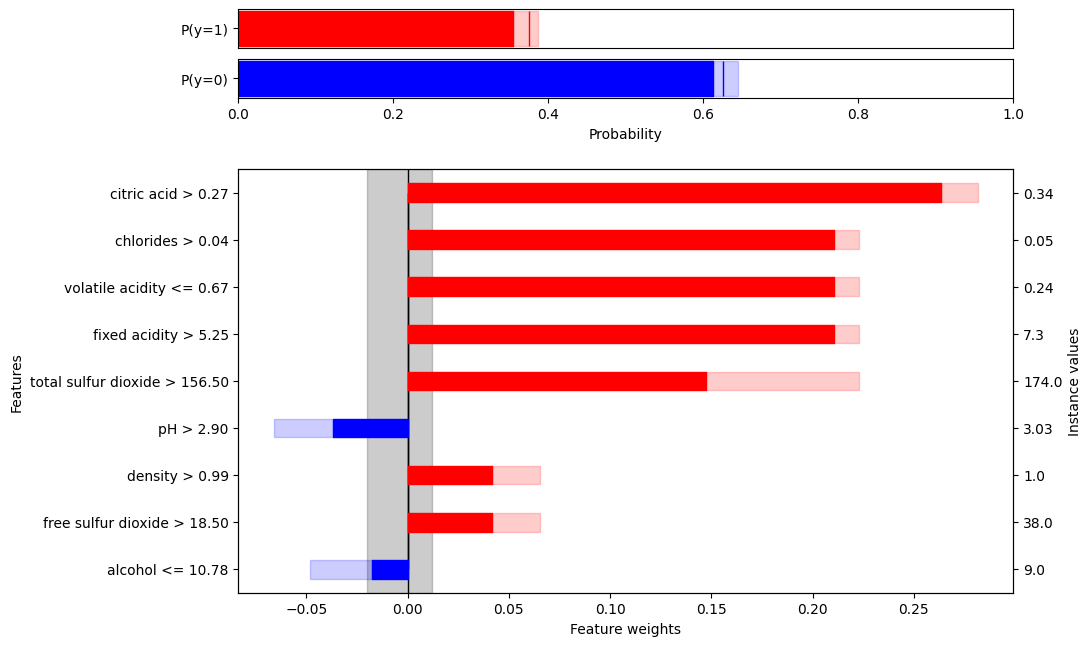

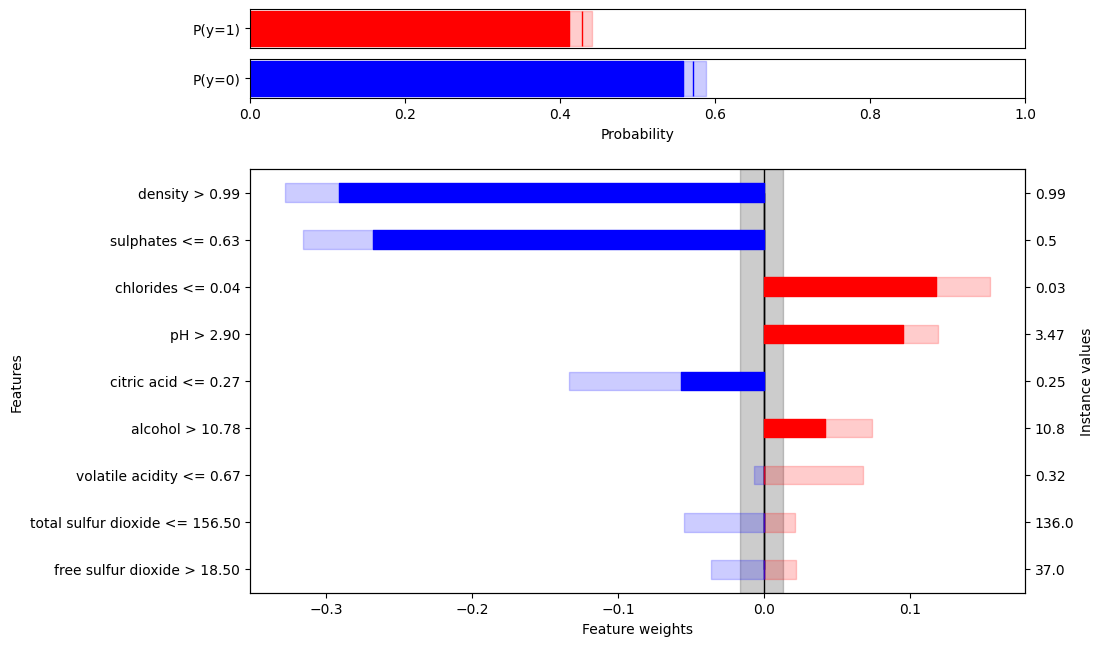

In [10]:
factual_explanations.add_conjunctions().plot()
factual_explanations.remove_conjunctions().plot(uncertainty=True)

All explanations support indexing using integer indexing, slices or boolean indexing.

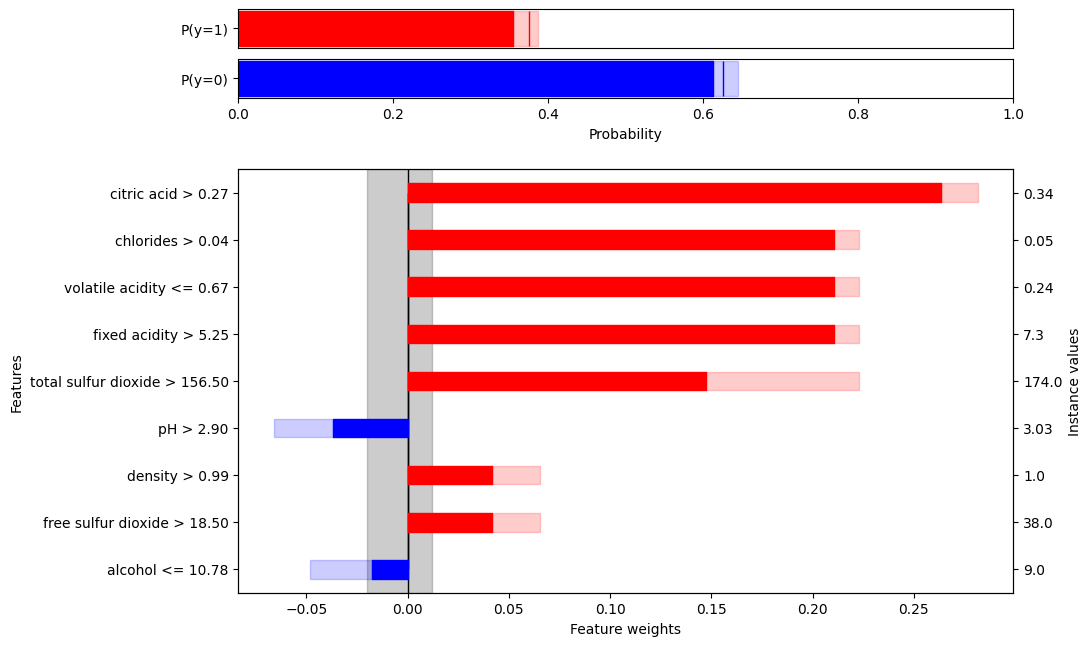

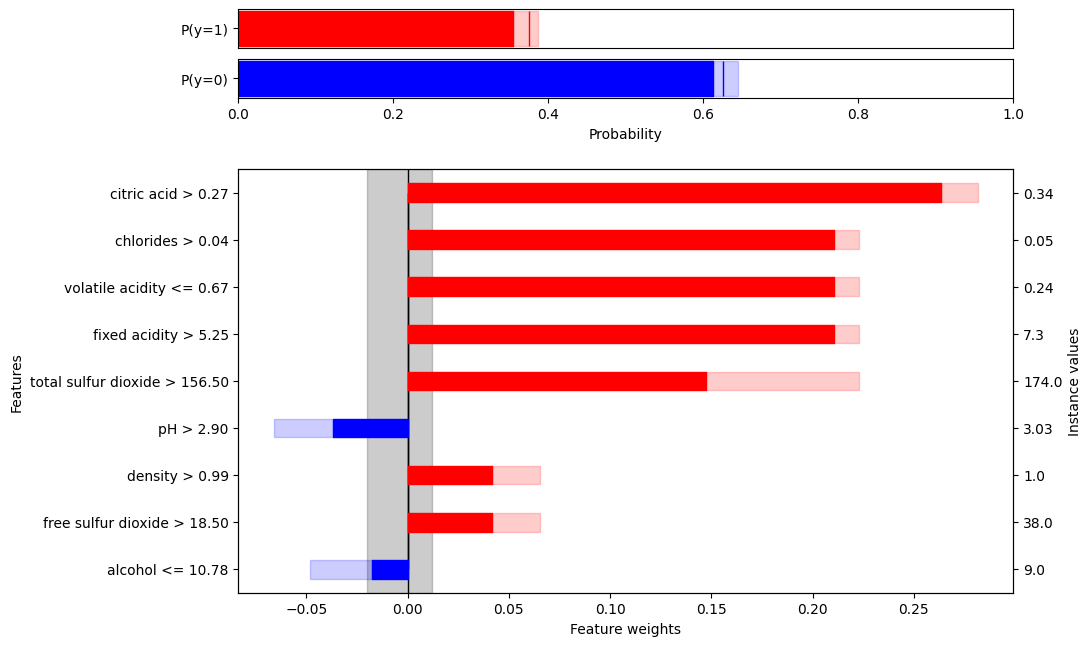

In [11]:
factual_explanations[0].plot(uncertainty=True)
factual_explanations[:1].plot(uncertainty=True)

#### Explore Alternative Explanations
An alternative to factual rules is to extract alternative rules, which is done using the `explore_alternatives` function. Alternative explanations provides insights on how predicted outcomes would change if specific input features were modified, including uncertainty estimates for these alternative outcomes.

In [12]:
alternative_explanations = classifier.explore_alternatives(X_test)
display(classifier)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=classification, discretizer=EntropyDiscretizer(), learner=RandomForestClassifier()))

Alternatives are also visualized using the `plot` function. Plotting an individual alternative explanation is easiest done using indexing. Adding or removing conjunctions is done as before.

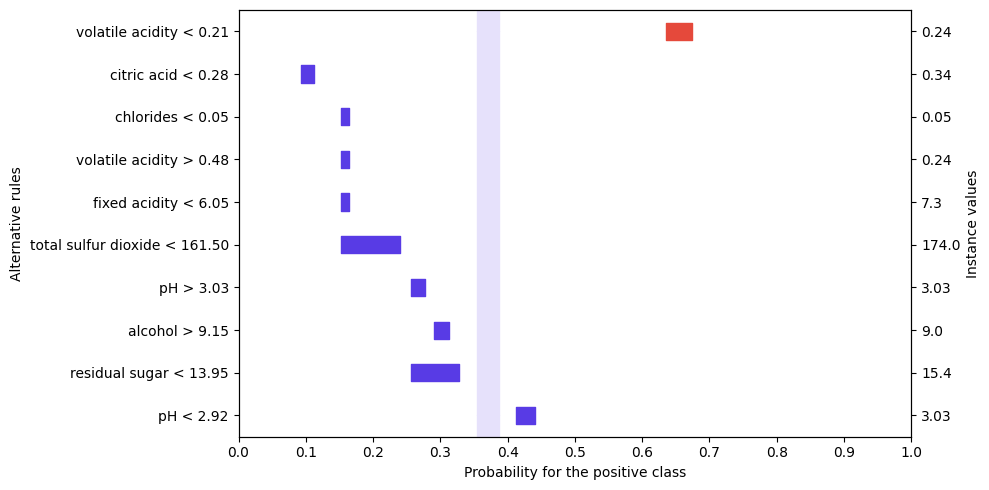

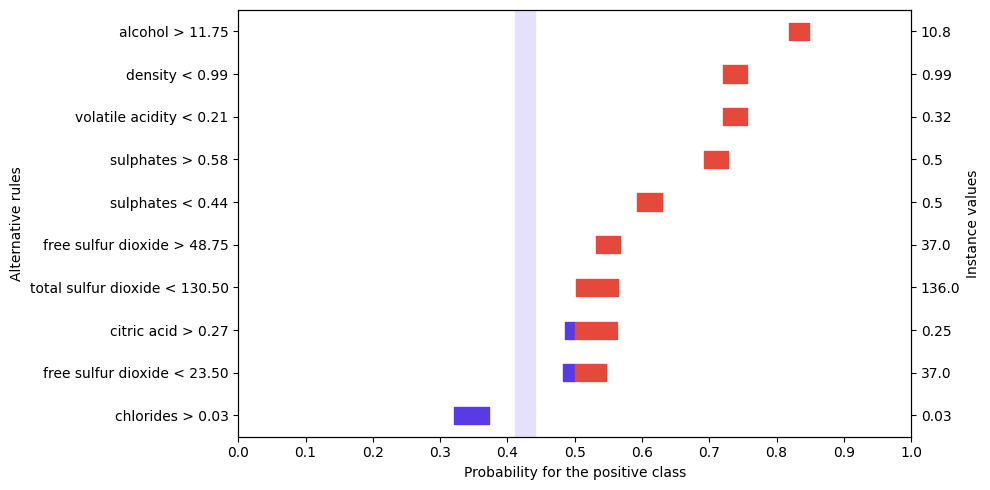

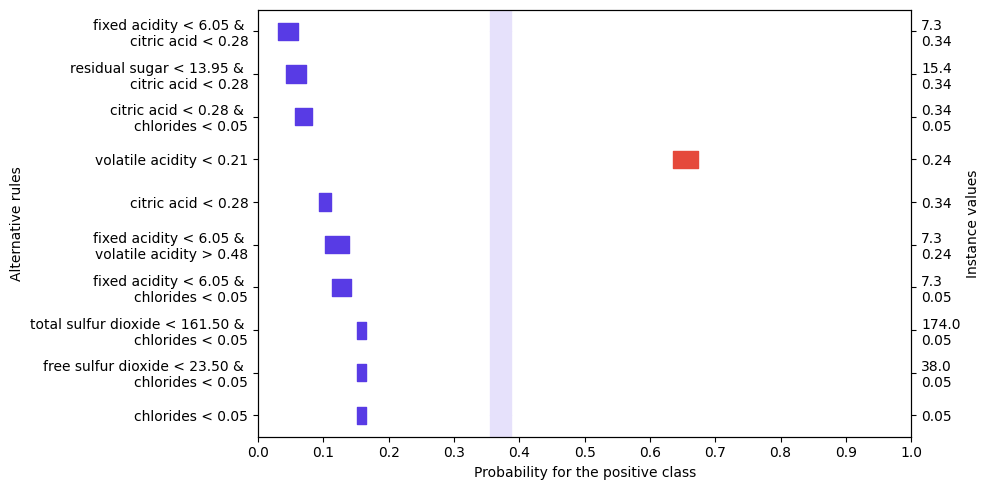

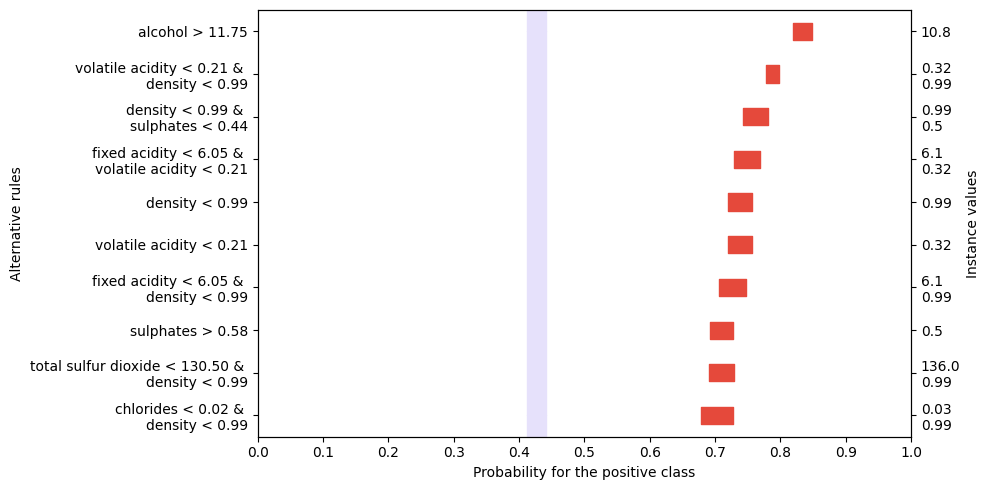

In [13]:
alternative_explanations.plot()
alternative_explanations.add_conjunctions().plot()

`calibrated_explanations` supports multiclass which is demonstrated in [demo_multiclass](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_multiclass.ipynb). That notebook also demonstrates how both feature names and target and categorical labels can be added to improve the interpretability. 
## Regression
Extracting explanations for regression is very similar to how it is done for classification. First we load and divide the dataset. The target is divided by 1000, meaning that the target is in thousands of dollars. 

In [14]:
dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values/1000
y_filter = y < 400
X = X[y_filter,:]
y = y[y_filter]

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2, random_state=42)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=200)

We now create our wrapper object, using a `RandomForestRegressor` as learner. 

In [15]:
from sklearn.ensemble import RandomForestRegressor

regressor = WrapCalibratedExplainer(RandomForestRegressor())
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=False, calibrated=False)

We now fit our model using the proper training set.

In [16]:
regressor.fit(X_prop_train, y_prop_train)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=False)

The `WrapCalibratedExplainer` class has a `predict` method that returns the predictions and probability estimates of the underlying classifier. If the model is not yet calibrated, then the underlying models `predict` method is used. If the model is calibrated, then the `predict` method of the calibration model is used.

In [17]:
prediction = regressor.predict(X_test)
print(f'Uncalibrated model prediction: \n{prediction}')

Uncalibrated model prediction: 
[165.518   295.47595]


c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\core.py:2009: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated predictions.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated predictions.", Warning)


Before we can generate explanations, we need to calibrate our model using the calibration set. 

In [18]:
regressor.calibrate(X_cal, y_cal, feature_names=feature_names)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=regression, learner=RandomForestRegressor(), difficulty_estimator=None))

We can easily add a difficulty estimator by assigning a `DifficultyEstimator` to the `difficulty_estimator` attribute when calibrating the model.

In [19]:
from crepes.extras import DifficultyEstimator

de = DifficultyEstimator().fit(X=X_prop_train, learner=regressor.learner, scaler=True)
regressor.calibrate(X_cal, y_cal, feature_names=feature_names, difficulty_estimator=de)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=regression, learner=RandomForestRegressor(), difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)))

Once the model is calibrated, the `predict`  method produce calibrated predictions with uncertainties. The default confidence is 90 per cent, which can be altered using the `low_high_percentiles` parameter. 

In [20]:
prediction, (low, high) = regressor.predict(X_test, uq_interval=True) # default low_high_percentiles=(5, 95)
print(f'Calibrated prediction: \n{prediction}')
print('Calibrated uncertainty interval:')
print([(low[i], high[i]) for i in range(len(low))])

Calibrated prediction: 
[166.84938007 296.19978851]
Calibrated uncertainty interval:
[(np.float64(-26.777043638615595), np.float64(301.2904239903441)), (np.float64(190.9298776839795), np.float64(369.2920681298666))]


You can also get the probability of the prediction being below a certain threshold using `predict_proba` by assigning the `threshold` parameter.

In [32]:
import numpy as np
prediction = regressor.predict(X_test, threshold=200)
print('Calibrated probabilistic prediction:')
print(prediction)

proba, (low, high) = regressor.predict_proba(X_test, uq_interval=True, threshold=200)
print('Calibrated probabilistic probability estimate [y_hat > threshold, y_hat <= threshold]:')
print(proba)
print('Calibrated probabilistic uncertainty interval for y_hat <= threshold ([lower_bound, upper_bound]):')
print(np.array([(low[i], high[i]) for i in range(len(low))]))

Calibrated probabilistic prediction:
['y_hat <= 200', 'y_hat > 200']
Calibrated probabilistic probability estimate [y_hat > threshold, y_hat <= threshold]:
[[0.2  0.8 ]
 [0.95 0.05]]
Calibrated probabilistic uncertainty interval for y_hat <= threshold ([lower_bound, upper_bound]):
[[0.75       1.        ]
 [0.         0.05263158]]


#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. 

In [22]:
factual_explanations = regressor.explain_factual(X_test)
display(regressor)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=regression, discretizer=BinaryRegressorDiscretizer(), learner=RandomForestRegressor(), difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)))

Regression also offer both regular and uncertainty plots for factual explanations with or without conjunctive rules, in almost exactly the same way as for classification. 

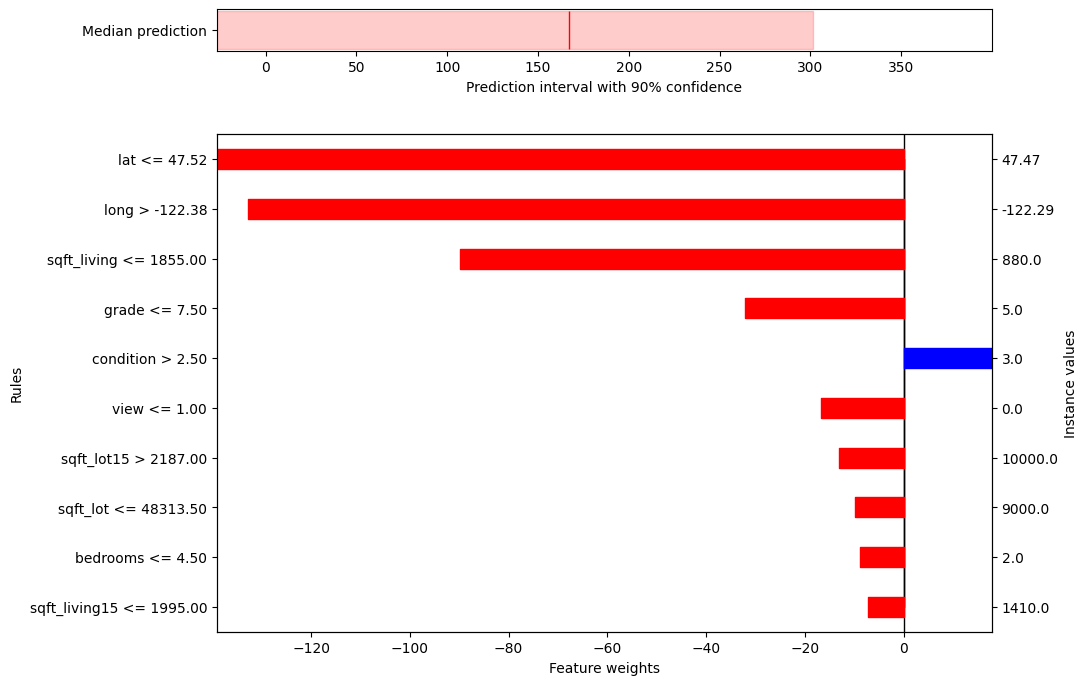

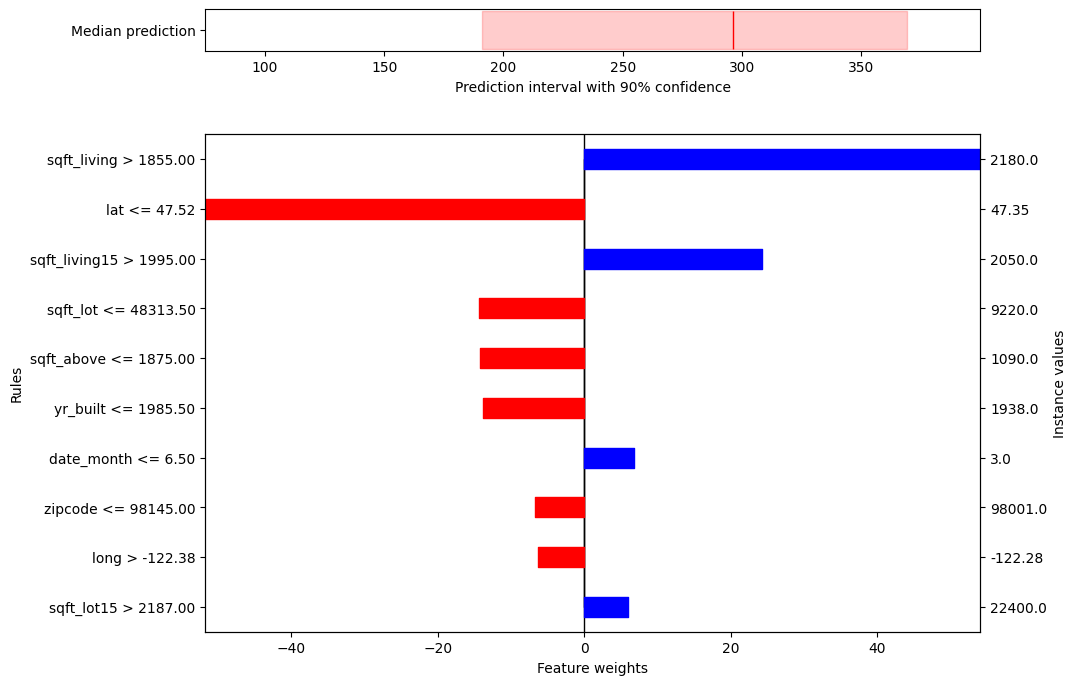

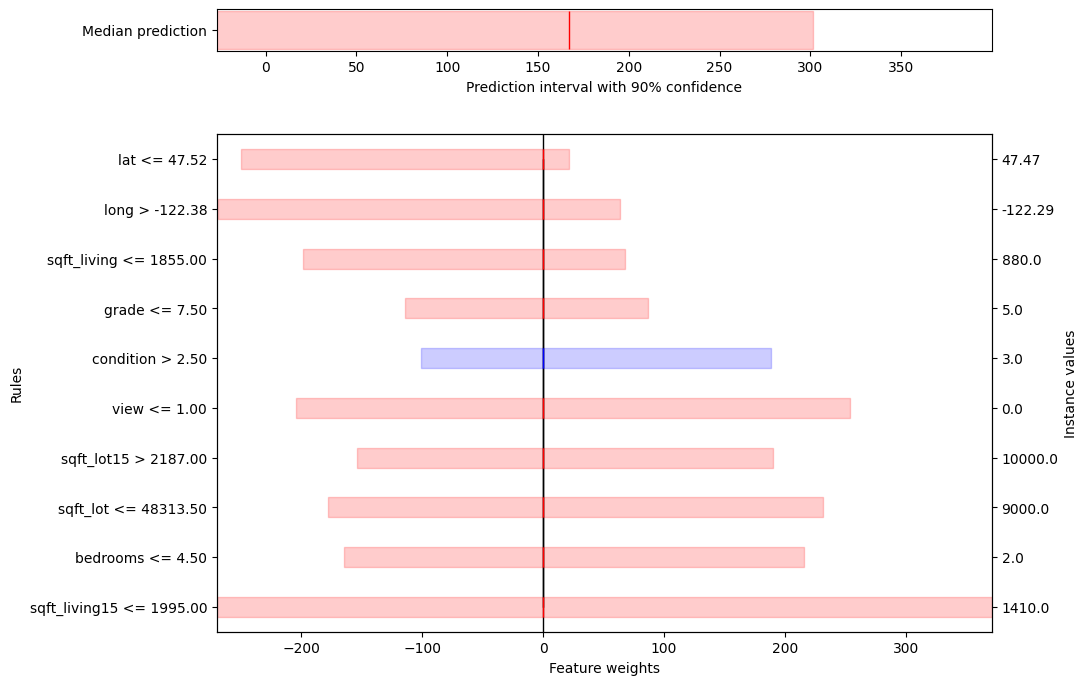

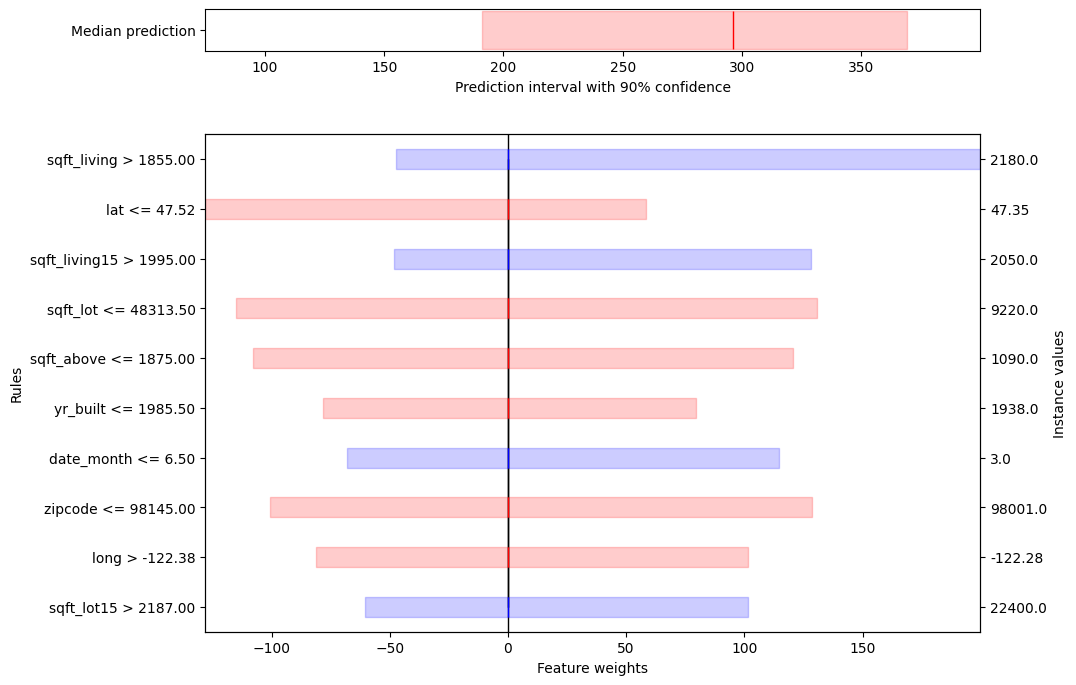

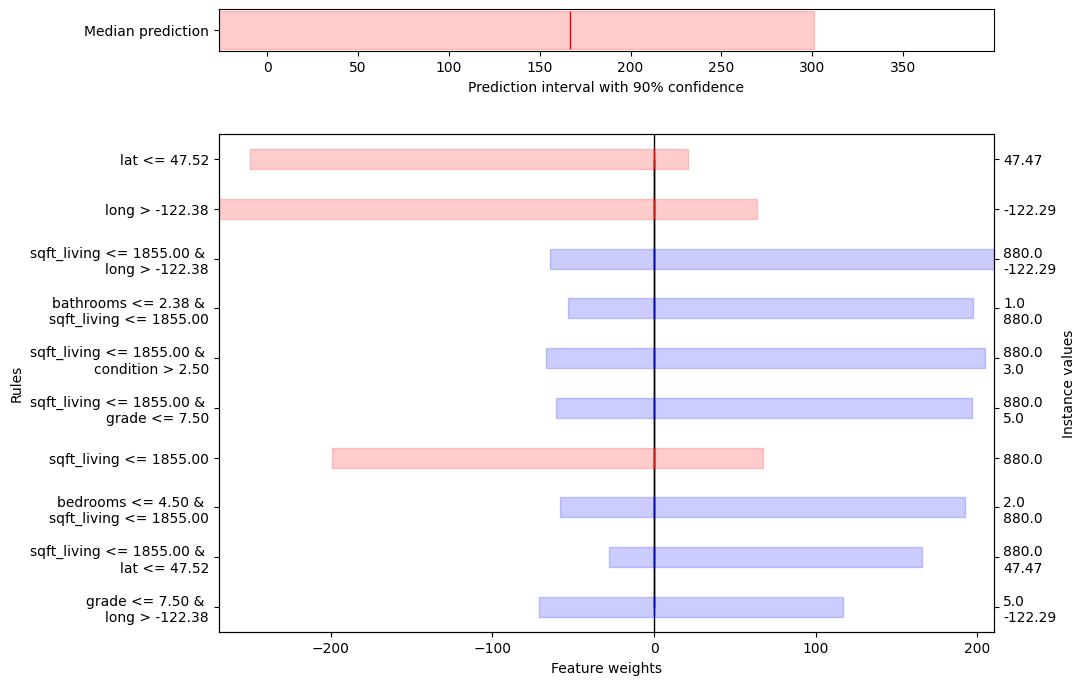

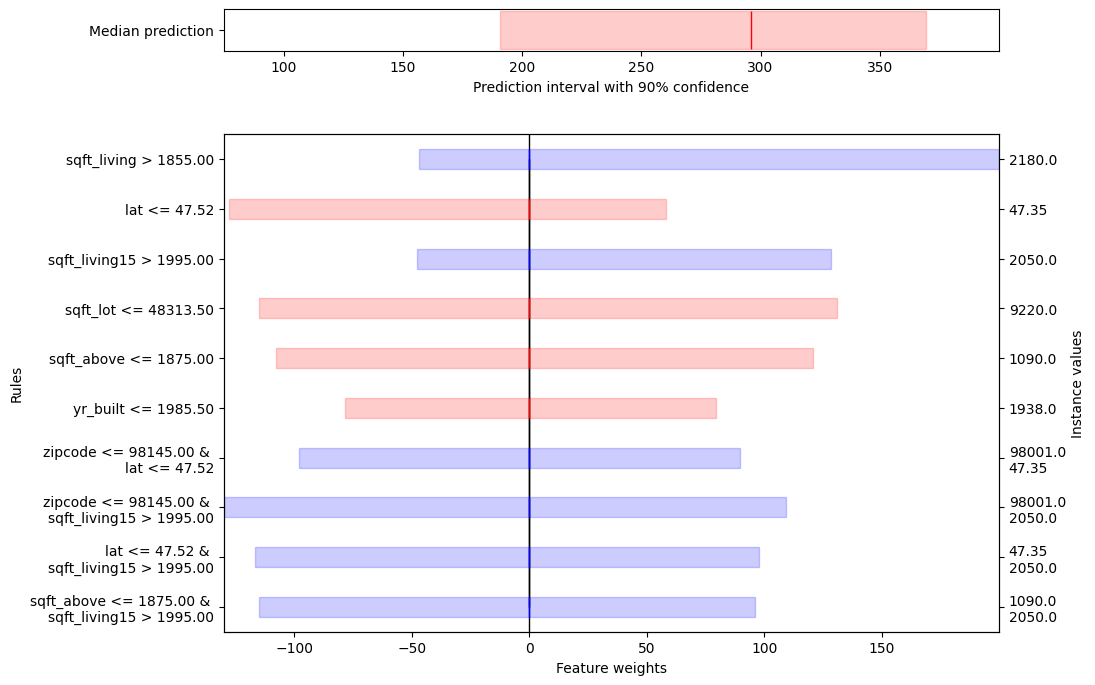

In [23]:
factual_explanations.plot()
factual_explanations.plot(uncertainty=True)

factual_explanations.add_conjunctions().plot(uncertainty=True)

Default, the confidence interval is set to a symmetric interval of 90% (defined as `low_high_percentiles=(5,95)`). The intervals can cover any user specified interval, including one-sided intervals. To define a one-sided upper-bounded 90% interval, set `low_high_percentiles=(-np.inf,90)`, and to define a one-sided lower-bounded 95% interval, set `low_high_percentiles=(5,np.inf)`. Percentiles can also be set to any other values in the range (0,100) (exclusive), and intervals do not have to be symmetric. 

In [24]:
lower_bounded_explanations = regressor.explain_factual(X_test, low_high_percentiles=(5,np.inf))
asymmetric_explanations = regressor.explain_factual(X_test, low_high_percentiles=(5,75))

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


#### Explore Alternative Explanations
The `explore_alternatives` will work exactly the same as for classification. 

In [25]:
alternative_explanations = regressor.explore_alternatives(X_test)
display(regressor)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=regression, discretizer=RegressorDiscretizer(), learner=RandomForestRegressor(), difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)))

Counterfactual plots work as for classification.

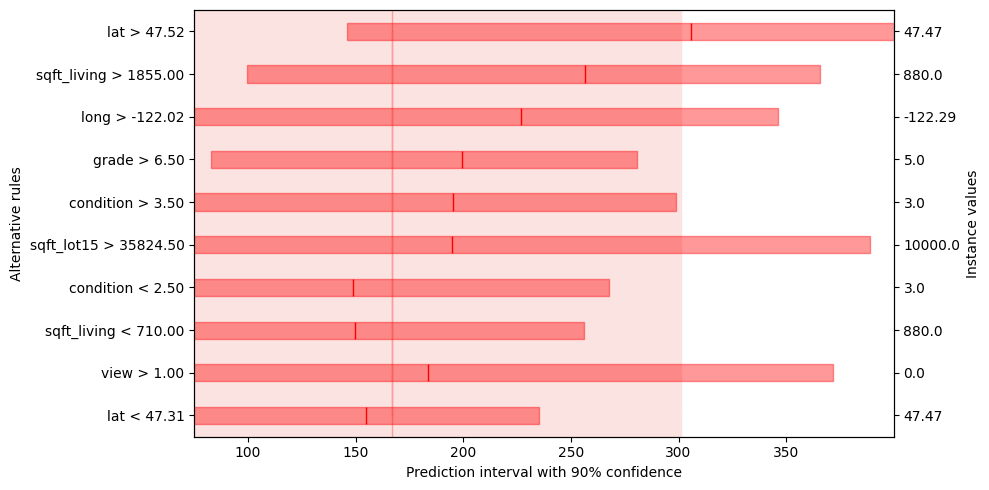

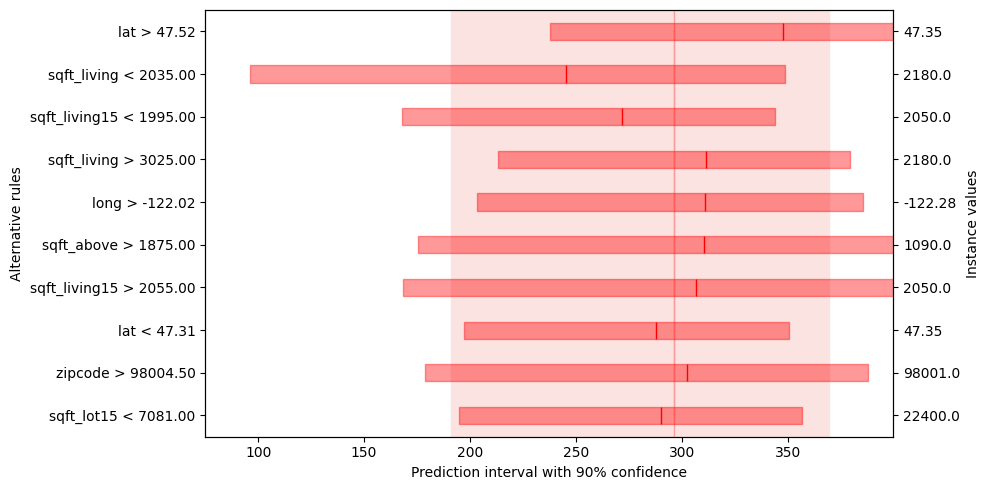

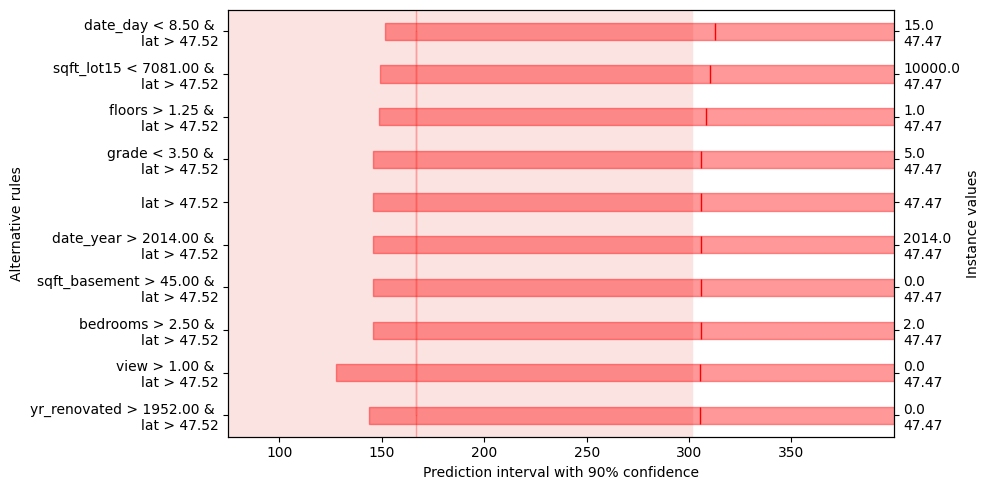

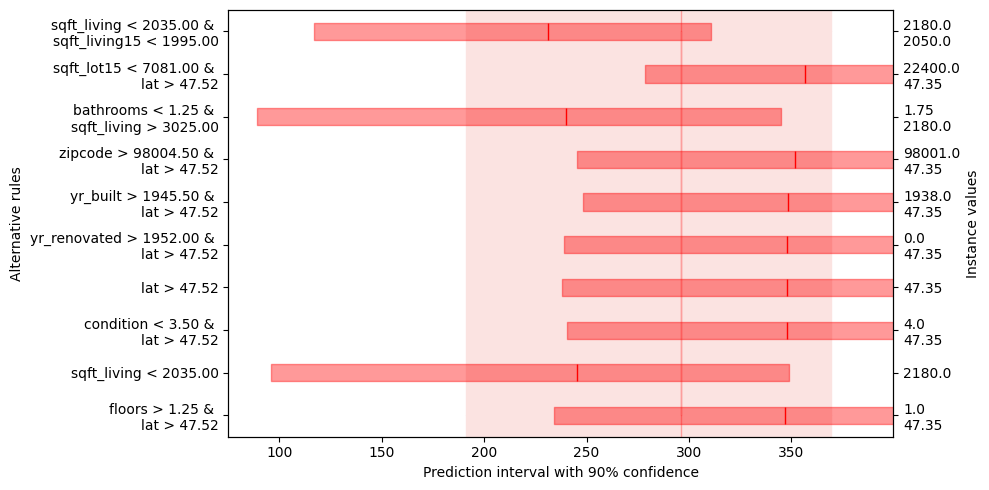

In [26]:
alternative_explanations.plot()
alternative_explanations.add_conjunctions().plot()

## Probabilistic Regression
The difference between probabilistic regression and regular regression is that the former returns a probability of the prediction being below a certain threshold. This could for example be useful when the prediction is a time to an event, such as time to death or time to failure. 

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


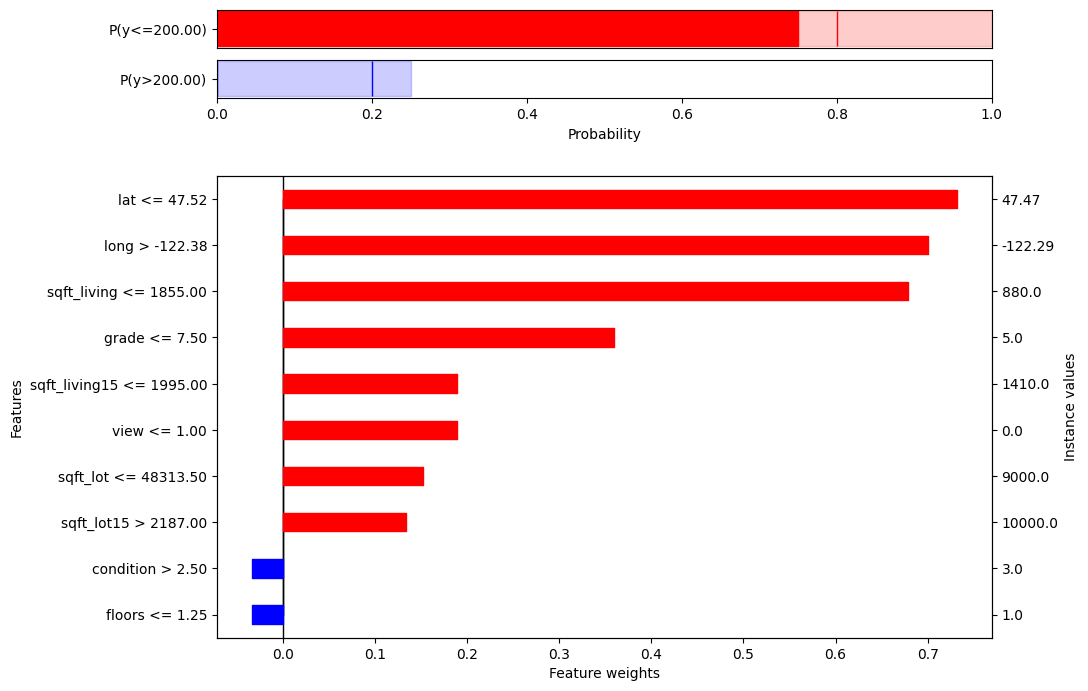

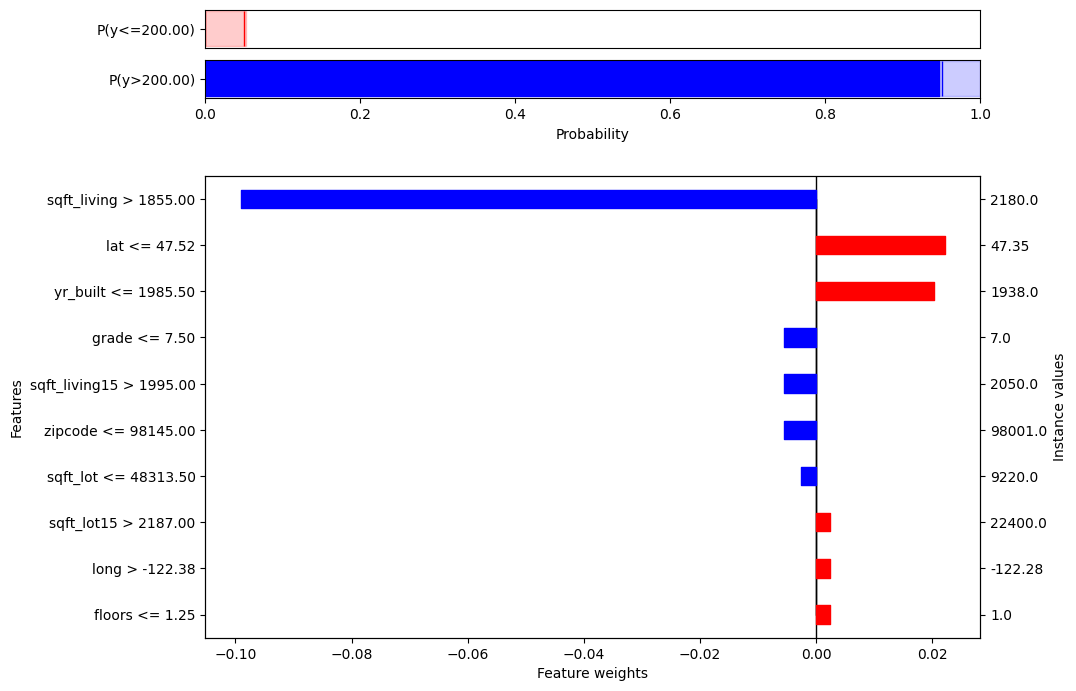

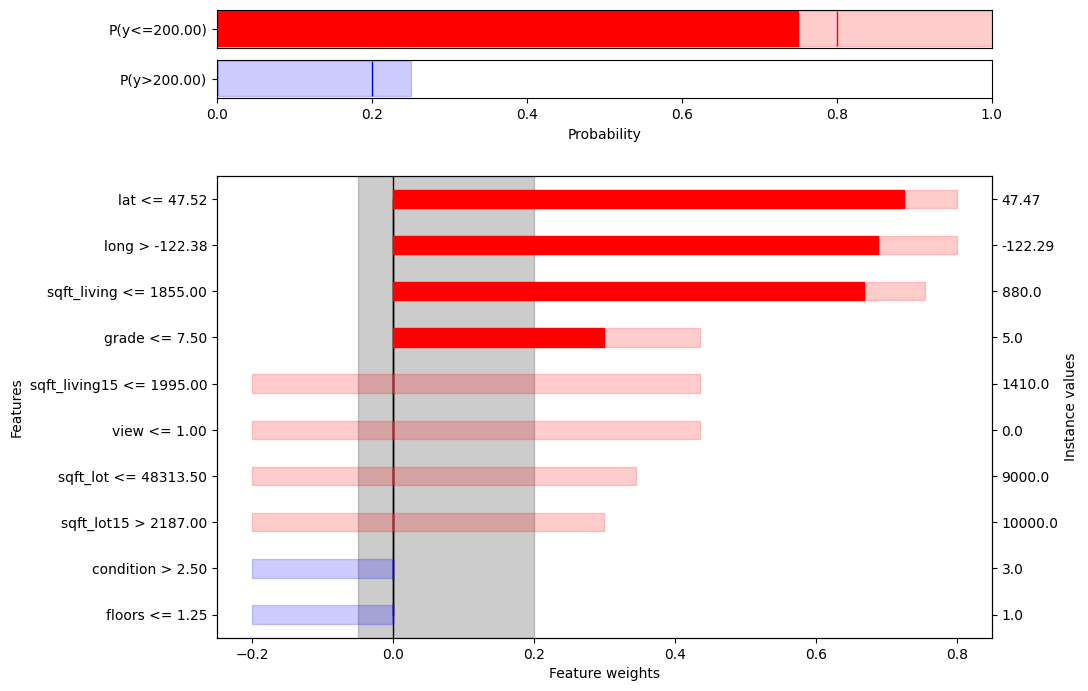

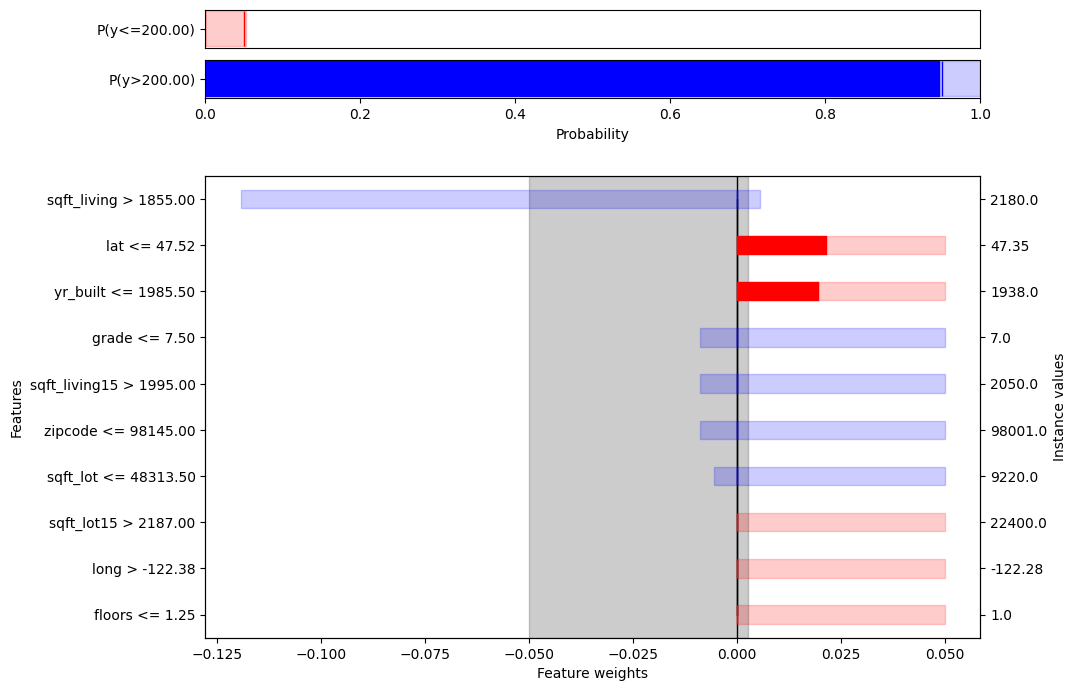

In [27]:
probabilistic_factual_explanations = regressor.explain_factual(X_test, threshold=200)
probabilistic_factual_explanations.plot()
probabilistic_factual_explanations.plot(uncertainty=True)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


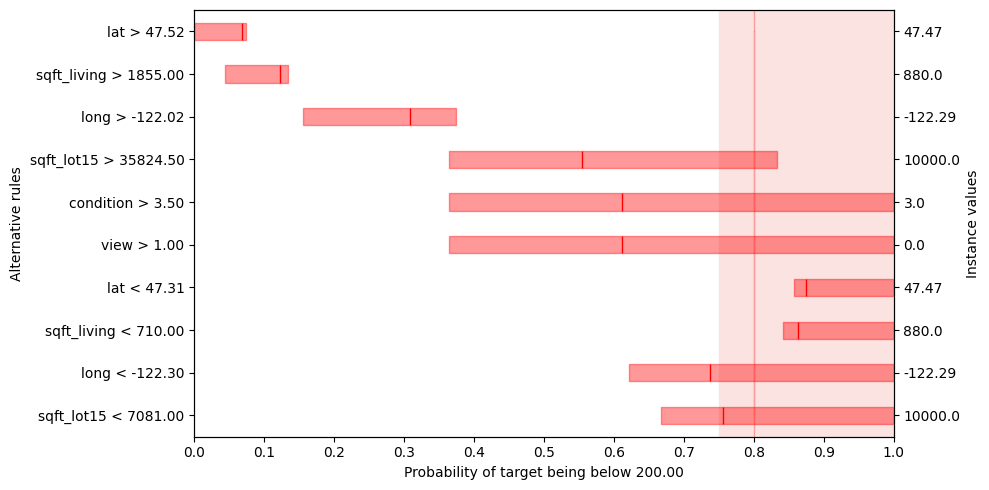

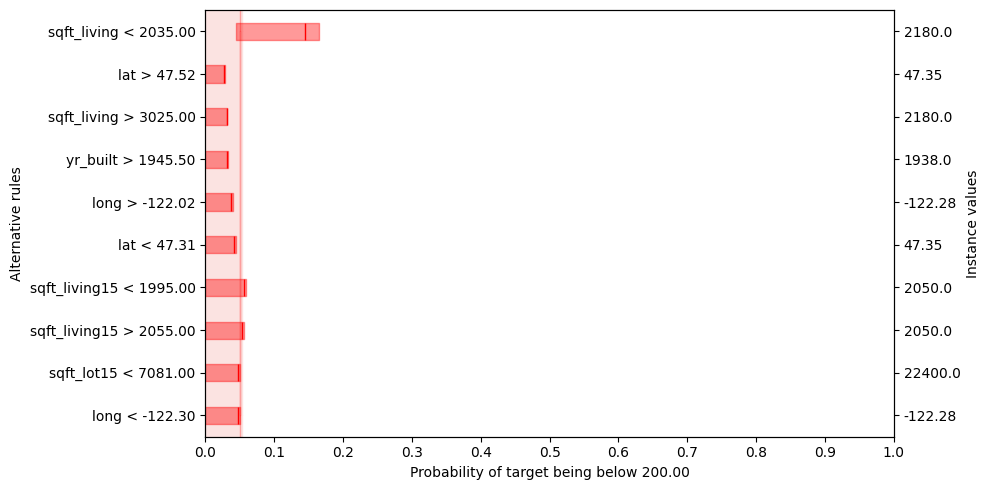

In [28]:
probabilistic_alternative_explanations = regressor.explore_alternatives(X_test, threshold=200)
probabilistic_alternative_explanations.plot()

Regression offers many more options but to learn more about them, see the [demo_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_regression.ipynb) or the [demo_probabilistic_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_probabilistic_regression.ipynb) notebooks.

A `WrapCalibratedExplainer` can also be initialized with a trained model or with a `CalibratedExplainer` object, as is examplified below. We use the `learner` and `explainer` from the previously initialized `classifier` and `regressor` instances, as we know that these are fitted and calibrated.  

In [29]:
new_classifier = WrapCalibratedExplainer(classifier.learner)
display(new_classifier)
new_classifier_explainer = WrapCalibratedExplainer(classifier.explainer)
display(new_classifier_explainer)

new_regressor = WrapCalibratedExplainer(regressor.learner)
display(new_regressor)
new_regressor_explainer = WrapCalibratedExplainer(regressor.explainer)
display(new_regressor_explainer)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=False)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=classification, discretizer=EntropyDiscretizer(), learner=RandomForestClassifier()))

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=False)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, 
		explainer=CalibratedExplainer(mode=regression, discretizer=RegressorDiscretizer(), learner=RandomForestRegressor(), difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)))

When a calibrated explainer is re-fitted, the explainer is reinitialized.